# Library

In [ ]:
!pip install skorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.9/228.9 kB 6.7 MB/s eta 0:00:00


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 14.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import os
import sys
import librosa
import librosa.display
import torch
import torch.nn as nn
import seaborn as sns
import soundfile as sf
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence
from skorch import NeuralNetClassifier
from sklearn.preprocessing import LabelEncoder
from skorch.callbacks import EarlyStopping, LRScheduler, EpochScoring
from scipy.fftpack import dct
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
from google.colab import drive
import warnings


if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_path_base = '/content/drive/MyDrive/dataset_full/'
data_folders = ['native', 'nonative']
phonics_directories = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
                      'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

phonics_labels = []
file_paths = []
speaker_groups = []

for data_folder in data_folders:
    data_path = os.path.join(data_path_base, data_folder)
    if data_folder == 'native':
        for phonics in phonics_directories:
            phonics_path = os.path.join(data_path, phonics)
            if os.path.exists(phonics_path):
                for file in os.listdir(phonics_path):
                    if file.endswith('.mp3'):
                        phonics_labels.append(phonics)
                        file_paths.append(os.path.join(phonics_path, file))
                        speaker_groups.append('native')
    else:
        for region in os.listdir(data_path):
            region_path = os.path.join(data_path, region)
            if os.path.isdir(region_path):
                for phonics in phonics_directories:
                    phonics_path = os.path.join(region_path, phonics)
                    if os.path.exists(phonics_path):
                        for file in os.listdir(phonics_path):
                            if file.endswith('.mp3'):
                                phonics_labels.append(phonics)
                                file_paths.append(os.path.join(phonics_path, file))
                                speaker_groups.append(region)

# Create DataFrame
dataset_df = pd.DataFrame({
    'Phonics': phonics_labels,
    'Speaker_Group': speaker_groups,
    'Path': file_paths})

# Check missing folders
for data_folder in data_folders:
    data_path = os.path.join(data_path_base, data_folder)
    if data_folder == 'native':
        missing = [p for p in phonics_directories if not os.path.exists(os.path.join(data_path, p))]
    else:
        for region in os.listdir(data_path):
            region_path = os.path.join(data_path, region)
            if os.path.isdir(region_path):
                missing = [p for p in phonics_directories if not os.path.exists(os.path.join(region_path, p))]

print(f"Total samples loaded: {len(dataset_df)}")
print(f"Unique phonics: {dataset_df['Phonics'].nunique()}")
print("\nPhonics label distribution:\n", dataset_df['Phonics'].value_counts().sort_index())
print("\nSpeaker group distribution:\n", dataset_df['Speaker_Group'].value_counts())

Total samples loaded: 986
Unique phonics: 26

Phonics label distribution:
 Phonics
a    38
b    38
c    38
d    38
e    38
f    38
g    38
h    38
i    38
j    38
k    38
l    38
m    38
n    38
o    38
p    38
q    36
r    38
s    38
t    38
u    38
v    38
w    38
x    38
y    38
z    38
Name: count, dtype: int64

Speaker group distribution:
 Speaker_Group
native    492
jawa      156
papua     104
batam      78
bali       78
madura     78
Name: count, dtype: int64


# Spectrogram

In [ ]:
def speed_perturb(y, rate=1.1):
    return librosa.effects.time_stretch(y, rate=rate)

def pitch_shift(y, sr, steps=1):
    return librosa.effects.pitch_shift(y, sr=sr, n_steps=steps)

In [ ]:
def plot_spectrogram(data, sample_rate, title, file_path=None):
    plt.figure(figsize=(10, 4))
    S = librosa.feature.melspectrogram(y=data, sr=sample_rate, n_mels=128)
    S_dB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_dB, sr=sample_rate, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    if file_path:
        plt.savefig(file_path)
        plt.close()
    else:
        plt.show()

# Setup save directory
save_path = '/content/drive/MyDrive/spectograms/experimentB/'
os.makedirs(save_path, exist_ok=True)

# Augment and plot
for index, row in dataset_df.iterrows():
    audio_path = row['Path']
    phonics_label = row['Phonics']

    data, sample_rate = librosa.load(audio_path, sr=None)

    # Original
    path_orig = os.path.join(save_path, f"{phonics_label}_original_{index}.png")
    plot_spectrogram(data, sample_rate, f"Original {phonics_label.upper()}", path_orig)

    # Speed Perturbation
    data_speed = speed_perturb(data, rate=1.1)
    path_speed = os.path.join(save_path, f"{phonics_label}_speed_{index}.png")
    plot_spectrogram(data_speed, sample_rate, f"Speed Perturbed {phonics_label.upper()}", path_speed)

    # Pitch Shift
    data_pitch = pitch_shift(data, sr=sample_rate, steps=2)
    path_pitch = os.path.join(save_path, f"{phonics_label}_pitch_{index}.png")
    plot_spectrogram(data_pitch, sample_rate, f"Pitch Shifted {phonics_label.upper()}", path_pitch)

print("Spectrograms saved successfully.")

Spectrograms saved successfully.


In [ ]:
def plot_spectrogram(data, sample_rate, title):
    plt.figure(figsize=(10, 4))
    S = librosa.feature.melspectrogram(y=data, sr=sample_rate, n_mels=128)
    S_dB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_dB, sr=sample_rate, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

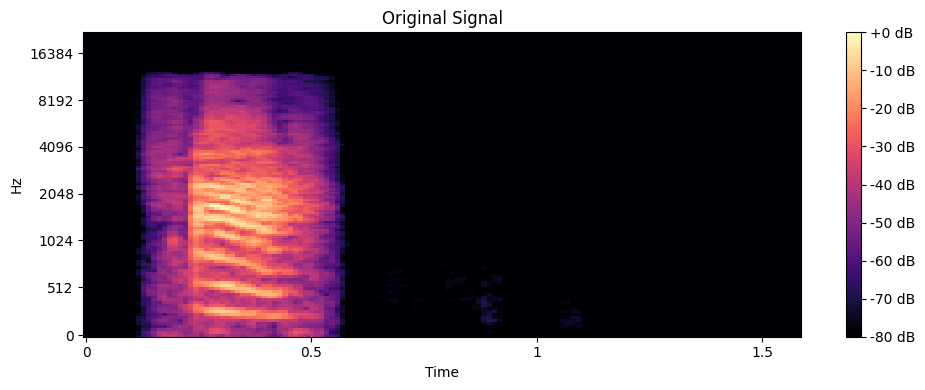

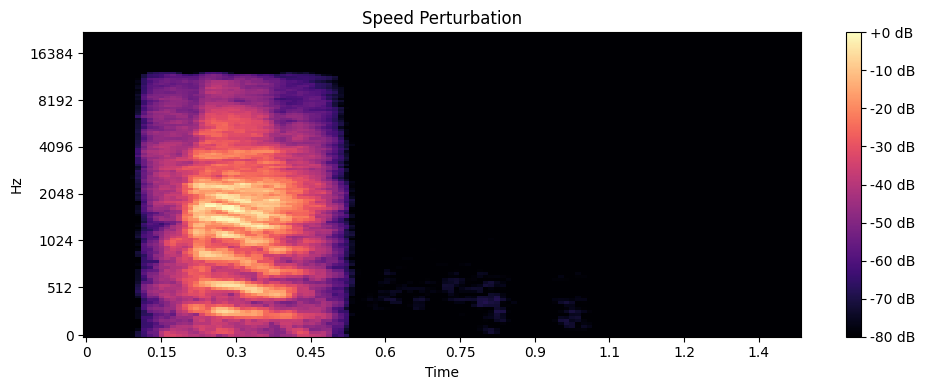

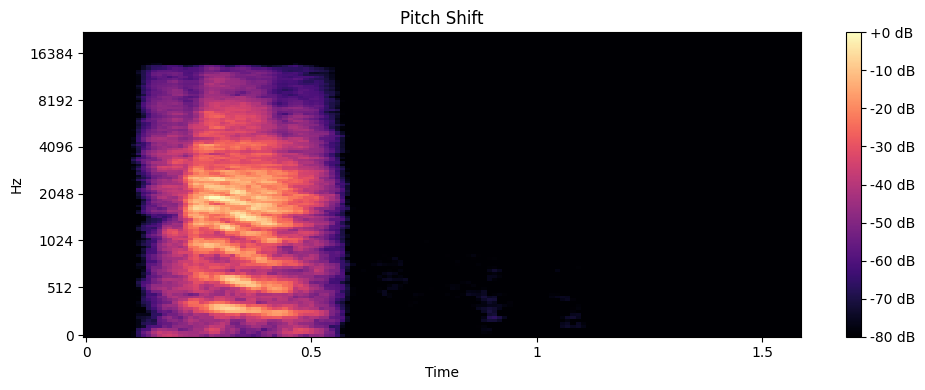

In [ ]:
sample_audio_path = dataset_df[dataset_df['Phonics'] == 'a']['Path'].iloc[0]
data_sample, sr_sample = librosa.load(sample_audio_path, sr=None)

speed_aug = speed_perturb(data_sample, rate=1.1)
pitch_aug = pitch_shift(data_sample, sr=sr_sample, steps=1)

plot_spectrogram(data_sample, sr_sample, 'Original Signal')
plot_spectrogram(speed_aug, sr_sample, 'Speed Perturbation')
plot_spectrogram(pitch_aug, sr_sample, 'Pitch Shift')

# Ekstraksi Fitur

In [ ]:
def medium_time_power(signal, M=2):
    padded = np.pad(signal, ((M, M), (0, 0)), mode='constant')
    return np.stack([
        np.mean(padded[i:i + 2 * M + 1], axis=0)
        for i in range(signal.shape[0])
    ])

def asym_lowpass(x, alpha=0.999, beta=0.5):
    y = np.zeros_like(x)
    y[0] = x[0]
    for i in range(1, len(x)):
        y[i] = np.where(x[i] >= y[i - 1],
                        alpha * y[i - 1] + (1 - alpha) * x[i],
                        beta * y[i - 1] + (1 - beta) * x[i])
    return y

def temporal_masking(x, lam=0.85, mu=0.2):
    peak = np.zeros_like(x)
    masked = np.zeros_like(x)
    peak[0] = x[0]
    masked[0] = x[0]
    for i in range(1, len(x)):
        peak[i] = np.maximum(lam * peak[i - 1], x[i])
        masked[i] = np.where(x[i] >= lam * peak[i - 1], x[i], mu * peak[i - 1])
    return masked

def weight_smoothing(x, ref, N=4):
    smoothed = np.zeros_like(x)
    for t in range(x.shape[0]):
        for f in range(x.shape[1]):
            l1 = max(f - N, 0)
            l2 = min(f + N + 1, x.shape[1])
            smoothed[t, f] = np.mean(x[t, l1:l2] / (ref[t, l1:l2] + 1e-6))
    return smoothed

def extract_pncc(data, sr, n_mels=40, n_fft=512, hop_length=160, win_length=400):
    try:
        data, _ = librosa.effects.trim(data, top_db=40)
        emphasized = scipy.signal.lfilter([1, -0.97], [1], data)

        stft = np.abs(librosa.stft(emphasized, n_fft=n_fft, hop_length=hop_length, win_length=win_length)) ** 2
        mel_basis = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels)
        mel_spec = np.dot(mel_basis, stft).T

        mt_power = medium_time_power(mel_spec)
        low_env = asym_lowpass(mt_power)
        subtracted = mt_power - low_env
        rectified = np.maximum(0, subtracted)
        floor = asym_lowpass(rectified)
        masked = temporal_masking(rectified)
        switched = np.where(mt_power >= 2 * low_env, masked, floor)
        smoothed = weight_smoothing(switched, mt_power)
        tf_norm = mel_spec * smoothed

        mean_power = np.zeros(tf_norm.shape[0])
        mean_power[0] = 0.0001
        for i in range(1, tf_norm.shape[0]):
            mean_power[i] = 0.999 * mean_power[i - 1] + 0.001 * np.mean(tf_norm[i])
        norm = tf_norm / (mean_power[:, None] + 1e-6)

        nonlin = norm ** (1 / 15)
        return (nonlin - np.mean(nonlin)) / (np.std(nonlin) + 1e-6)
    except:
        return None

In [ ]:
def extract_tensor1d_pncc(data, sr):
    spec = extract_pncc(data, sr)
    if spec is None or np.isnan(spec).any() or np.isinf(spec).any():
        return None
    return torch.tensor(spec, dtype=torch.float32)

In [ ]:
def extract_all_features(dataset_df):
    cnn_data, rnn_data, transformer_data = [], [], []
    for idx, row in dataset_df.iterrows():
        path = row['Path']
        label = row['Phonics']
        try:
            data, sr = librosa.load(path, sr=None, mono=True)
            if len(data) < 1024:
                continue
            variants = [
                data,
                librosa.effects.time_stretch(data, rate=1.1),
                librosa.effects.pitch_shift(data, sr=sr, n_steps=1)
            ]
            for v in variants:
                tensor = extract_tensor1d_pncc(v, sr)
                if tensor is not None and tensor.ndim == 2 and not torch.isnan(tensor).any() and not torch.isinf(tensor).any():
                    cnn_data.append((tensor, str(label)))
                    rnn_data.append((tensor, str(label)))
                    transformer_data.append((tensor, str(label)))
        except:
            continue

    all_labels = [label for _, label in cnn_data + rnn_data + transformer_data]
    if not all_labels:
        return {}

    label_encoder = LabelEncoder()
    label_encoder.fit(all_labels)

    def prepare_seq_data(data):
        if not data:
            return np.array([]), np.array([]), np.array([]), np.array([])
        try:
            X, y = zip(*data)
            X = [x.float() if not isinstance(x, torch.FloatTensor) else x for x in X]
            y_encoded = label_encoder.transform(y)
            X_train_list, X_test_list, y_train, y_test = train_test_split(
                list(X), list(y_encoded), test_size=0.2, stratify=y_encoded, random_state=42)
            X_train = pad_sequence(X_train_list, batch_first=True).numpy()
            X_test = pad_sequence(X_test_list, batch_first=True).numpy()
            return X_train, X_test, np.array(y_train), np.array(y_test)
        except:
            return np.array([]), np.array([]), np.array([]), np.array([])

    X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = prepare_seq_data(cnn_data)
    X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = prepare_seq_data(rnn_data)
    X_train_t, X_test_t, y_train_t, y_test_t = prepare_seq_data(transformer_data)

    return {
        'label_encoder': label_encoder,
        'cnn': (X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn),
        'rnn': (X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn),
        'transformer': (X_train_t, X_test_t, y_train_t, y_test_t)
    }


# Example call
features = extract_all_features(dataset_df)
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = features['cnn']
X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = features['rnn']
X_train_t, X_test_t, y_train_t, y_test_t = features['transformer']


In [ ]:
print("CNN Dataset:")
print(f"Train: {X_train_cnn.shape[0]} samples")
print(f"Test : {X_test_cnn.shape[0]} samples\n")

print("RNN Dataset:")
print(f"Train: {X_train_rnn.shape[0]} samples")
print(f"Test : {X_test_rnn.shape[0]} samples\n")

print("Transformer Dataset:")
print(f"Train: {X_train_t.shape[0]} samples")
print(f"Test : {X_test_t.shape[0]} samples")

CNN Dataset:
Train: 2366 samples
Test : 592 samples

RNN Dataset:
Train: 2366 samples
Test : 592 samples

Transformer Dataset:
Train: 2366 samples
Test : 592 samples


# Modelling

# CNN

### Optuna (0.907)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import optuna
from torch.optim.lr_scheduler import CosineAnnealingLR
from skorch.helper import predefined_split
from skorch.callbacks import Callback, LRScheduler, EpochScoring
from skorch import NeuralNetClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import numpy as np

class AdaptiveEarlyStopping(Callback):
    def __init__(self, patience=5, threshold=0.001):
        self.patience = patience
        self.threshold = threshold
        self.best_score = -np.inf
        self.wait = 0

    def on_epoch_end(self, net, **kwargs):
        current_score = net.history[-1]['valid_acc']
        if current_score - self.best_score > self.threshold:
            self.best_score = current_score
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                old_lr = net.optimizer_.param_groups[0]['lr']
                new_lr = old_lr * 0.5
                print(f"\nReducing LR from {old_lr:.2e} to {new_lr:.2e}")
                for param_group in net.optimizer_.param_groups:
                    param_group['lr'] = new_lr
                self.wait = 0

class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _ = x.size()
        y = self.pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1)
        return x * y.expand_as(x)

class CNN_Classifier(nn.Module):
    def __init__(self, input_shape, num_classes, n_blocks, conv_params, dropout, fc_units=256, use_bn=True):
        super().__init__()
        self.blocks = nn.ModuleList()
        in_channels = input_shape[1]

        for i in range(n_blocks):
            out_channels = conv_params[i]['out_channels']
            kernel_size = conv_params[i]['kernel_size']
            pool_size = conv_params[i]['pool_size']
            block_dropout = conv_params[i]['dropout']

            block = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size, padding=kernel_size // 2),
                nn.BatchNorm1d(out_channels),
                nn.ReLU(),
                nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm1d(out_channels),
                nn.ReLU(),
                SEBlock(out_channels),
                nn.MaxPool1d(pool_size),
                nn.Dropout(block_dropout)
            )
            self.blocks.append(block)
            in_channels = out_channels

        self.global_pool = nn.AdaptiveAvgPool1d(1)
        classifier_layers = [nn.Linear(in_channels, fc_units)]
        if use_bn:
            classifier_layers.append(nn.BatchNorm1d(fc_units))
        classifier_layers.extend([
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(fc_units, num_classes)
        ])
        self.classifier = nn.Sequential(*classifier_layers)

    def forward(self, x):
        x = x.transpose(1, 2)
        for block in self.blocks:
            x = block(x)
        x = self.global_pool(x).squeeze(-1)
        return self.classifier(x)

def objective(trial, X_train, y_train, X_val, y_val, num_classes):
    n_blocks = trial.suggest_int('n_blocks', 2, 4)
    dropout = trial.suggest_float('dropout', 0.2, 0.5)
    fc_units = trial.suggest_categorical('fc_units', [128, 256, 512])
    use_bn = trial.suggest_categorical('use_bn', [True, False])

    conv_params = []
    for i in range(n_blocks):
        conv_params.append({
            'out_channels': trial.suggest_categorical(f'channels_{i}', [64, 128, 256]),
            'kernel_size': trial.suggest_int(f'kernel_{i}', 3, 7, step=2),
            'pool_size': trial.suggest_int(f'pool_{i}', 1, 2),
            'dropout': trial.suggest_float(f'block_dropout_{i}', 0.1, 0.4)
        })

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = CNN_Classifier(
        input_shape=X_train.shape[1:],
        num_classes=num_classes,
        n_blocks=n_blocks,
        conv_params=conv_params,
        dropout=dropout,
        fc_units=fc_units,
        use_bn=use_bn
    ).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train)),
        batch_size=32, shuffle=True
    )

    val_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(torch.FloatTensor(X_val), torch.LongTensor(y_val)),
        batch_size=32
    )

    scheduler = CosineAnnealingLR(optimizer, T_max=100)
    best_acc = 0

    for epoch in range(100):
        model.train()
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
        scheduler.step()

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                outputs = model(x_batch)
                _, predicted = torch.max(outputs.data, 1)
                total += y_batch.size(0)
                correct += (predicted == y_batch).sum().item()

        val_acc = correct / total
        trial.report(val_acc, epoch)
        if val_acc > best_acc:
            best_acc = val_acc
        if trial.should_prune():
            raise optuna.TrialPruned()

    return best_acc

def train_cnn(X_train, y_train, X_test, y_test, label_encoder):
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)
    study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
    study.optimize(
        lambda trial: objective(trial, X_train, y_train, X_val, y_val, len(label_encoder.classes_)),
        n_trials=50
    )

    best_params = study.best_trial.params
    print(f"\nBest hyperparameters: {best_params}")

    conv_params = []
    for i in range(best_params['n_blocks']):
        conv_params.append({
            'out_channels': best_params[f'channels_{i}'],
            'kernel_size': best_params[f'kernel_{i}'],
            'pool_size': best_params[f'pool_{i}'],
            'dropout': best_params[f'block_dropout_{i}']
        })

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    best_model = CNN_Classifier(
        input_shape=X_train.shape[1:],
        num_classes=len(label_encoder.classes_),
        n_blocks=best_params['n_blocks'],
        conv_params=conv_params,
        dropout=best_params['dropout'],
        fc_units=best_params['fc_units'],
        use_bn=best_params['use_bn']
    ).to(device)

    net = NeuralNetClassifier(
        best_model,
        max_epochs=60,
        batch_size=32,
        optimizer=torch.optim.AdamW,
        optimizer__lr=0.001,
        criterion=nn.CrossEntropyLoss(),
        device=device,
        callbacks=[
            AdaptiveEarlyStopping(patience=5),
            LRScheduler(CosineAnnealingLR, T_max=60),
            EpochScoring('accuracy', name='valid_acc')
        ],
        train_split=predefined_split(
            torch.utils.data.TensorDataset(torch.FloatTensor(X_val), torch.LongTensor(y_val))
        )
    )

    net.fit(X_train.astype(np.float32), y_train.astype(np.longlong))
    y_pred = net.predict(X_test.astype(np.float32))
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    return net

# Example usage
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = features['cnn']
label_encoder = features['label_encoder']
best_model = train_cnn(X_train_cnn, y_train_cnn, X_test_cnn, y_test_cnn, label_encoder)


[I 2025-06-01 19:16:03,383] A new study created in memory with name: no-name-14fd20d9-cbb6-4621-b171-b3ad59786b64
[I 2025-06-01 19:16:53,315] Trial 0 finished with value: 0.8818565400843882 and parameters: {'n_blocks': 2, 'dropout': 0.39692794307075463, 'fc_units': 512, 'use_bn': False, 'channels_0': 128, 'kernel_0': 3, 'pool_0': 2, 'block_dropout_0': 0.1899642629044097, 'channels_1': 64, 'kernel_1': 7, 'pool_1': 1, 'block_dropout_1': 0.10892332578644259}. Best is trial 0 with value: 0.8818565400843882.
[I 2025-06-01 19:17:56,121] Trial 1 finished with value: 0.9071729957805907 and parameters: {'n_blocks': 3, 'dropout': 0.4142664066929978, 'fc_units': 128, 'use_bn': True, 'channels_0': 128, 'kernel_0': 5, 'pool_0': 1, 'block_dropout_0': 0.12426648049332215, 'channels_1': 64, 'kernel_1': 5, 'pool_1': 2, 'block_dropout_1': 0.3193883928657386, 'channels_2': 64, 'kernel_2': 7, 'pool_2': 1, 'block_dropout_2': 0.23937774128552597}. Best is trial 1 with value: 0.9071729957805907.
[I 2025-06-0


Best hyperparameters: {'n_blocks': 2, 'dropout': 0.301227037501224, 'fc_units': 256, 'use_bn': True, 'channels_0': 128, 'kernel_0': 7, 'pool_0': 2, 'block_dropout_0': 0.24536591921444195, 'channels_1': 256, 'kernel_1': 3, 'pool_1': 2, 'block_dropout_1': 0.1842794501695956}
  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        2.8093       0.2722        2.3939  0.0010  0.5756
      2        2.2516       0.3059        2.1862  0.0010  0.5683
      3        1.9897       0.3713        1.8880  0.0010  0.5714
      4        1.7650       0.3713        1.8833  0.0010  0.5567
      5        1.6235       0.4346        1.6840  0.0010  0.5586
      6        1.5008       0.4747        1.5389  0.0010  0.5609
      7        1.3476       0.4937        1.4859  0.0010  0.5524
      8        1.2243       0.4979        1.4076  0.0010  0.5538
      9        1.0991       0.5169        1.3268  0.0010  0.5453
     10   

Accuracy : 0.9071
Precision: 0.9132
Recall   : 0.9074
F1 Score : 0.9067

Classification Report:
              precision    recall  f1-score   support

           a       0.82      0.82      0.82        22
           b       1.00      1.00      1.00        23
           c       0.83      0.65      0.73        23
           d       0.89      0.70      0.78        23
           e       0.92      0.96      0.94        23
           f       1.00      0.96      0.98        23
           g       0.74      1.00      0.85        23
           h       0.88      0.91      0.89        23
           i       0.86      0.86      0.86        22
           j       0.95      0.91      0.93        23
           k       0.66      0.83      0.73        23
           l       0.89      0.74      0.81        23
           m       0.88      0.96      0.92        23
           n       0.95      0.87      0.91        23
           o       0.92      1.00      0.96        23
           p       1.00      0.96      

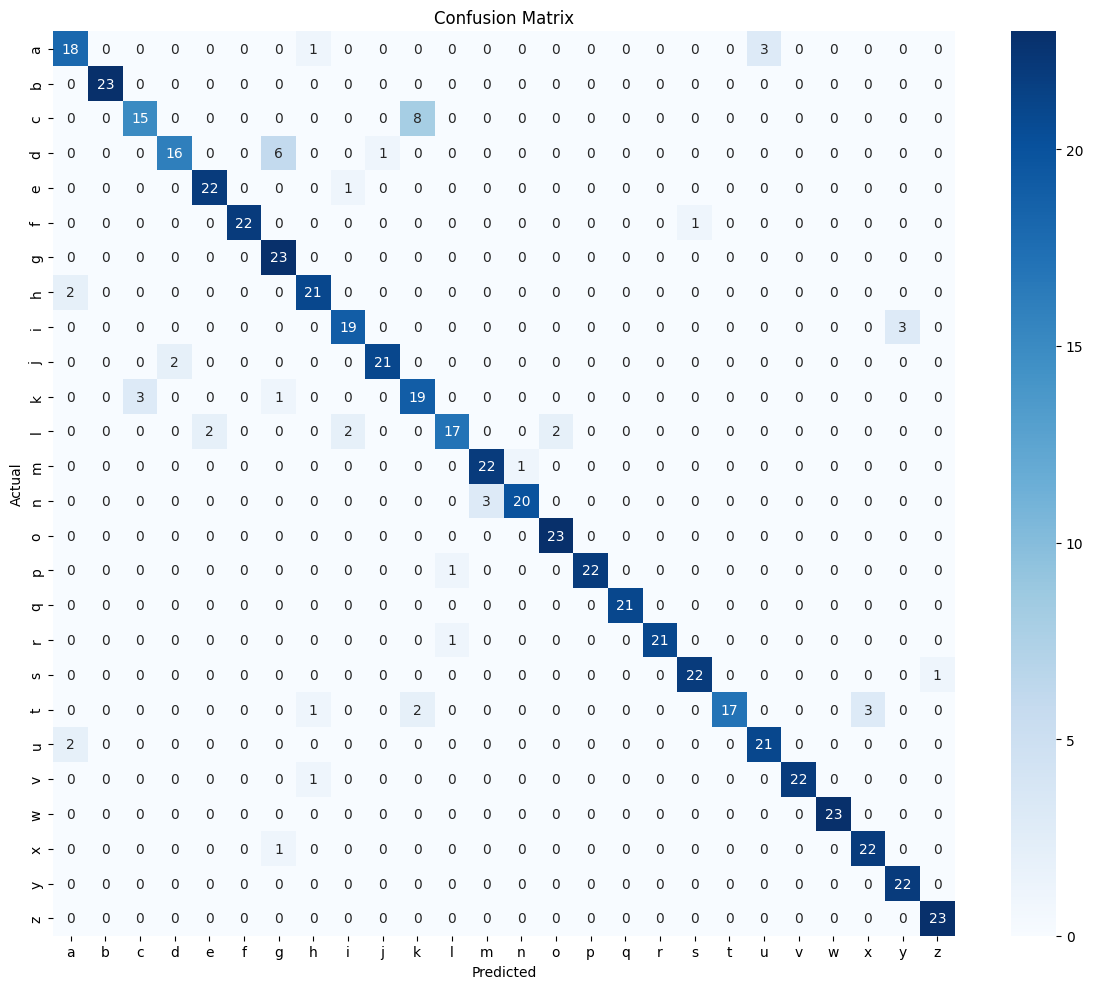

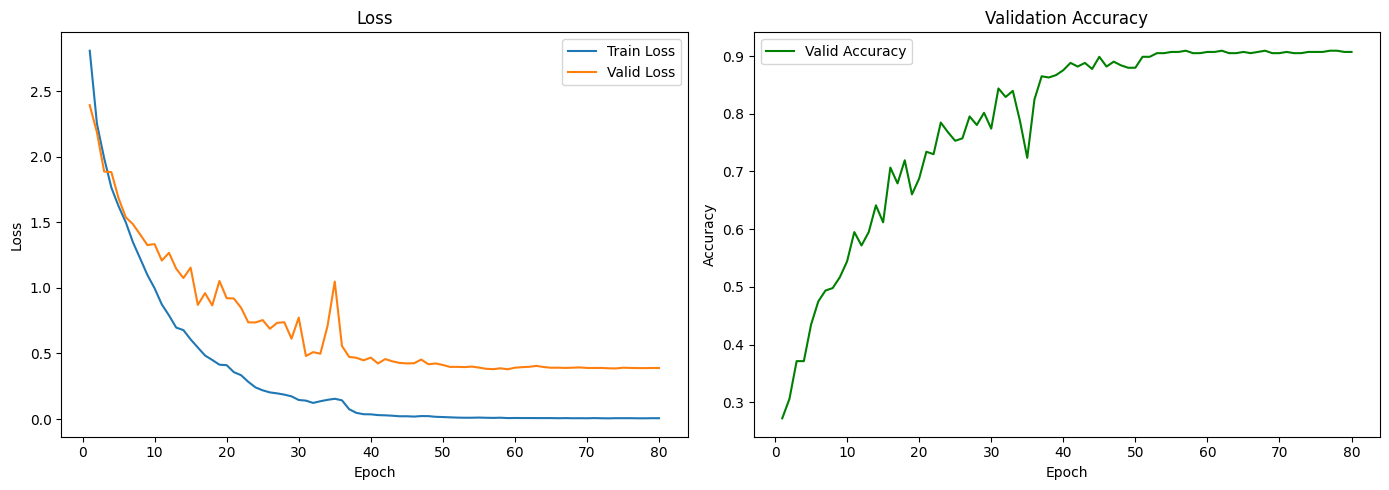

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, confusion_matrix
)

def evaluate_model(model, X_test, y_test, label_encoder):
    y_pred = model.predict(X_test.astype(np.float32))

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro')
    rec = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}\n")

    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()


def plot_training_history(model):
    history = model.history
    epochs = len(history)

    train_loss = history[:, 'train_loss']
    val_loss = history[:, 'valid_loss']
    val_acc = history[:, 'valid_acc']

    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    ax[0].plot(range(1, epochs+1), train_loss, label='Train Loss')
    ax[0].plot(range(1, epochs+1), val_loss, label='Valid Loss')
    ax[0].set_title('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    ax[1].plot(range(1, epochs+1), val_acc, label='Valid Accuracy', color='green')
    ax[1].set_title('Validation Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

evaluate_model(best_model, X_test_cnn, y_test_cnn, label_encoder)
plot_training_history(best_model)


# RNN

### GRU Optuna (0.945)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import optuna
import numpy as np
from torch.nn.utils.rnn import pad_sequence
from torch.optim.lr_scheduler import CosineAnnealingLR
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping, LRScheduler, EpochScoring, Callback
from skorch.helper import predefined_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import os, contextlib

class AdaptiveEarlyStopping(Callback):
    def __init__(self, patience=5, threshold=0.001):
        self.patience = patience
        self.threshold = threshold
        self.best_score = -np.inf
        self.wait = 0

    def on_epoch_end(self, net, **kwargs):
        current_score = net.history[-1]['valid_acc']
        if current_score - self.best_score > self.threshold:
            self.best_score = current_score
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                old_lr = net.optimizer_.param_groups[0]['lr']
                new_lr = old_lr * 0.5
                print(f"\n[LR Reduction] Reducing LR from {old_lr:.2e} to {new_lr:.2e}")
                for param_group in net.optimizer_.param_groups:
                    param_group['lr'] = new_lr
                self.wait = 0

class RNN_GRU(nn.Module):
    def __init__(self, input_dim, num_classes,
                 gru_hidden_size=320, num_layers=2,
                 attention_heads=4, dense_size=512,
                 dropout=0.3, bidirectional=True,
                 activation_fn='mish'):
        super().__init__()

        self.activation = (
            nn.ReLU() if activation_fn == 'relu'
            else nn.GELU() if activation_fn == 'gelu'
            else nn.Mish()
        )

        self.gru = nn.GRU(
            input_dim,
            gru_hidden_size,
            num_layers=num_layers,
            bidirectional=bidirectional,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        self.attention = nn.MultiheadAttention(
            embed_dim=gru_hidden_size * (2 if bidirectional else 1),
            num_heads=attention_heads,
            dropout=dropout,
            batch_first=True
        )

        self.classifier = nn.Sequential(
            nn.Linear(gru_hidden_size * (2 if bidirectional else 1), dense_size),
            self.activation,
            nn.LayerNorm(dense_size),
            nn.Dropout(dropout),
            nn.Linear(dense_size, num_classes)
        )

    def forward(self, x):
        gru_out, _ = self.gru(x)
        attn_out, _ = self.attention(gru_out, gru_out, gru_out)
        pooled = attn_out.mean(dim=1)
        return self.classifier(pooled)

def gru_optuna(X_train, y_train, X_test, y_test, label_encoder):
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
    )

    X_train_tensor = [torch.tensor(x, dtype=torch.float32) for x in X_train]
    X_val_tensor = [torch.tensor(x, dtype=torch.float32) for x in X_val]
    X_test_tensor = [torch.tensor(x, dtype=torch.float32) for x in X_test]

    X_train_pad = pad_sequence(X_train_tensor, batch_first=True).numpy()
    X_val_pad = pad_sequence(X_val_tensor, batch_first=True).numpy()
    X_test_pad = pad_sequence(X_test_tensor, batch_first=True).numpy()

    def objective(trial):
        input_dim = X_train_pad.shape[-1]
        num_classes = len(label_encoder.classes_)

        model = RNN_GRU(
            input_dim=input_dim,
            num_classes=num_classes,
            gru_hidden_size=trial.suggest_categorical('gru_hidden_size', [256, 320, 384]), #try 128 256
            num_layers=trial.suggest_int('num_layers', 1, 3),
            attention_heads=trial.suggest_categorical('attention_heads', [2, 4, 8]),
            dense_size=trial.suggest_categorical('dense_size', [384, 512, 640]),
            dropout=trial.suggest_float('dropout', 0.2, 0.4, step=0.05),
            bidirectional=trial.suggest_categorical('bidirectional', [True, False]),
            activation_fn=trial.suggest_categorical('activation_fn', ['relu', 'gelu', 'mish'])
        )

        net = NeuralNetClassifier(
            module=model,
            max_epochs=60,
            batch_size=32,
            optimizer=torch.optim.AdamW,
            optimizer__lr=0.001,
            criterion=nn.CrossEntropyLoss(label_smoothing=0.1),
            device='cuda' if torch.cuda.is_available() else 'cpu',
            train_split=predefined_split(
                torch.utils.data.TensorDataset(
                    torch.FloatTensor(X_val_pad),
                    torch.LongTensor(y_val)
                )
            ),
            callbacks=[
                ('adapt', AdaptiveEarlyStopping(patience=5)),
                ('sched', LRScheduler(CosineAnnealingLR, T_max=60)),
                ('score', EpochScoring('accuracy', name='valid_acc'))
            ],
            verbose=0
        )

        with open(os.devnull, 'w') as devnull:
            with contextlib.redirect_stdout(devnull):
                net.fit(X_train_pad.astype(np.float32), np.array(y_train).astype(np.longlong))

        for epoch, acc in enumerate(net.history[:, 'valid_acc']):
            trial.report(acc, step=epoch)
            if trial.should_prune():
                raise optuna.TrialPruned()

        return max(net.history[:, 'valid_acc'])

    study = optuna.create_study(
        direction='maximize',
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=5)
    )
    study.optimize(objective, n_trials=30, show_progress_bar=True)

    print("\nBest hyperparameters:")
    print(study.best_params)

    best_params = study.best_params
    input_dim = X_train_pad.shape[-1]
    num_classes = len(label_encoder.classes_)

    final_model = RNN_GRU(
        input_dim=input_dim,
        num_classes=num_classes,
        gru_hidden_size=best_params['gru_hidden_size'],
        num_layers=best_params['num_layers'],
        attention_heads=best_params['attention_heads'],
        dense_size=best_params['dense_size'],
        dropout=best_params['dropout'],
        bidirectional=best_params['bidirectional'],
        activation_fn=best_params['activation_fn']
    )

    final_net = NeuralNetClassifier(
        final_model,
        max_epochs=60,
        batch_size=32,
        optimizer=torch.optim.AdamW,
        optimizer__lr=0.001,
        criterion=nn.CrossEntropyLoss(label_smoothing=0.1),
        device='cuda' if torch.cuda.is_available() else 'cpu',
        train_split=predefined_split(
            torch.utils.data.TensorDataset(
                torch.FloatTensor(X_val_pad),
                torch.LongTensor(y_val)
            )
        ),
        callbacks=[
            ('adapt', AdaptiveEarlyStopping(patience=5)),
            ('sched', LRScheduler(CosineAnnealingLR, T_max=80)),
            ('score', EpochScoring('accuracy', name='valid_acc'))
        ],
        verbose=1
    )

    final_net.fit(X_train_pad.astype(np.float32), np.array(y_train).astype(np.longlong))
    y_pred = final_net.predict(X_test_pad.astype(np.float32))
    print("\nFinal Classification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    return final_net

X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = features['rnn']
label_encoder = features['label_encoder']
best_gru_model = gru_optuna(X_train_rnn, y_train_rnn, X_test_rnn, y_test_rnn, label_encoder)

[I 2025-06-01 19:28:38,463] A new study created in memory with name: no-name-bfab3b0d-3b5d-4f9c-8365-82265bd8bab7


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-06-01 19:33:32,026] Trial 0 finished with value: 0.9451476793248945 and parameters: {'gru_hidden_size': 320, 'num_layers': 1, 'attention_heads': 4, 'dense_size': 512, 'dropout': 0.25, 'bidirectional': False, 'activation_fn': 'relu'}. Best is trial 0 with value: 0.9451476793248945.
[I 2025-06-01 19:46:44,845] Trial 1 finished with value: 0.9324894514767933 and parameters: {'gru_hidden_size': 320, 'num_layers': 2, 'attention_heads': 4, 'dense_size': 512, 'dropout': 0.35000000000000003, 'bidirectional': True, 'activation_fn': 'relu'}. Best is trial 0 with value: 0.9451476793248945.
[I 2025-06-01 19:58:38,869] Trial 2 finished with value: 0.9472573839662447 and parameters: {'gru_hidden_size': 256, 'num_layers': 2, 'attention_heads': 8, 'dense_size': 384, 'dropout': 0.25, 'bidirectional': True, 'activation_fn': 'relu'}. Best is trial 2 with value: 0.9472573839662447.
[I 2025-06-01 20:04:42,797] Trial 3 finished with value: 0.9345991561181435 and parameters: {'gru_hidden_size': 256, 

Accuracy : 0.9459
Precision: 0.9499
Recall   : 0.9461
F1 Score : 0.9460

Classification Report:
              precision    recall  f1-score   support

           a       1.00      0.91      0.95        22
           b       0.95      0.91      0.93        23
           c       0.94      0.74      0.83        23
           d       0.92      1.00      0.96        23
           e       1.00      0.91      0.95        23
           f       1.00      0.91      0.95        23
           g       1.00      1.00      1.00        23
           h       0.96      0.96      0.96        23
           i       0.95      0.86      0.90        22
           j       1.00      0.91      0.95        23
           k       0.78      0.91      0.84        23
           l       0.88      1.00      0.94        23
           m       0.96      0.96      0.96        23
           n       0.92      0.96      0.94        23
           o       0.88      0.91      0.89        23
           p       0.88      1.00      

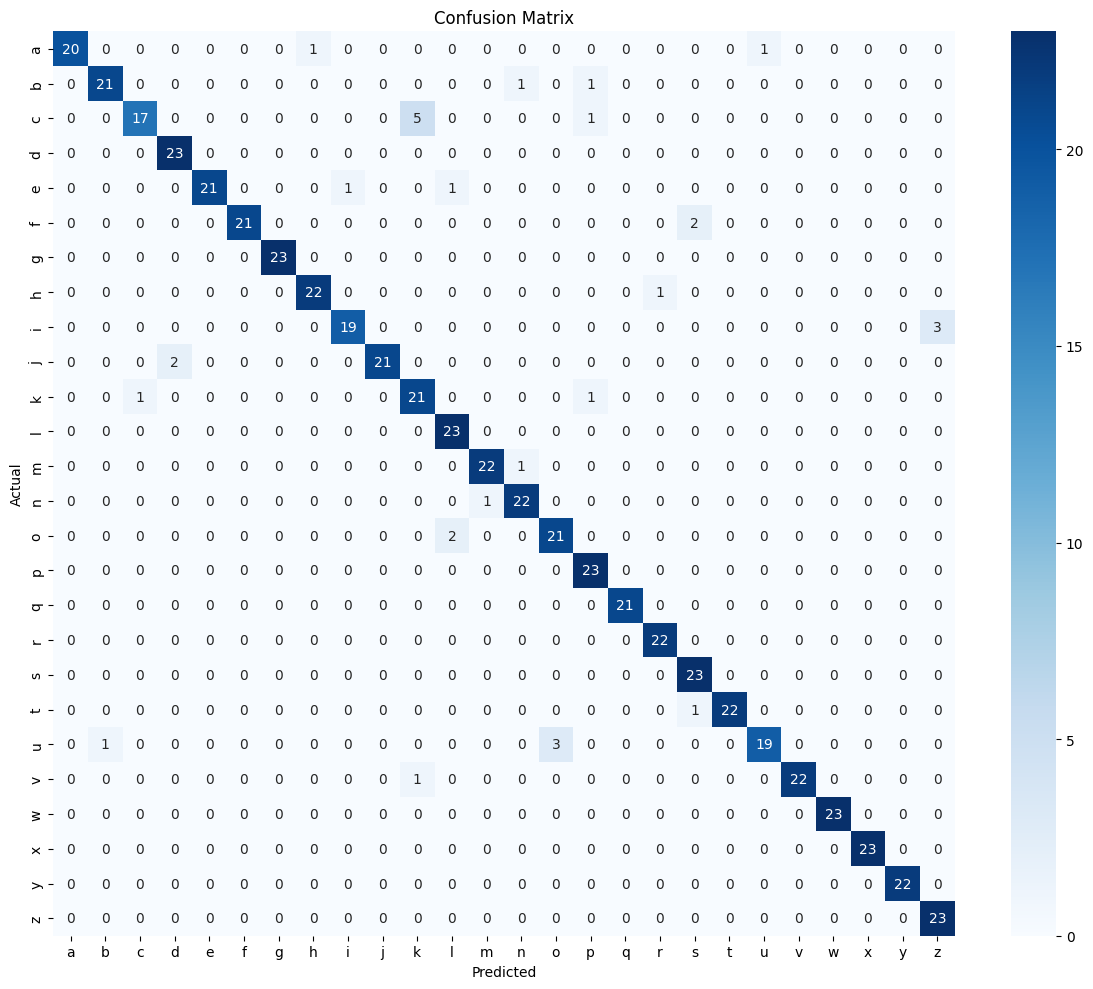

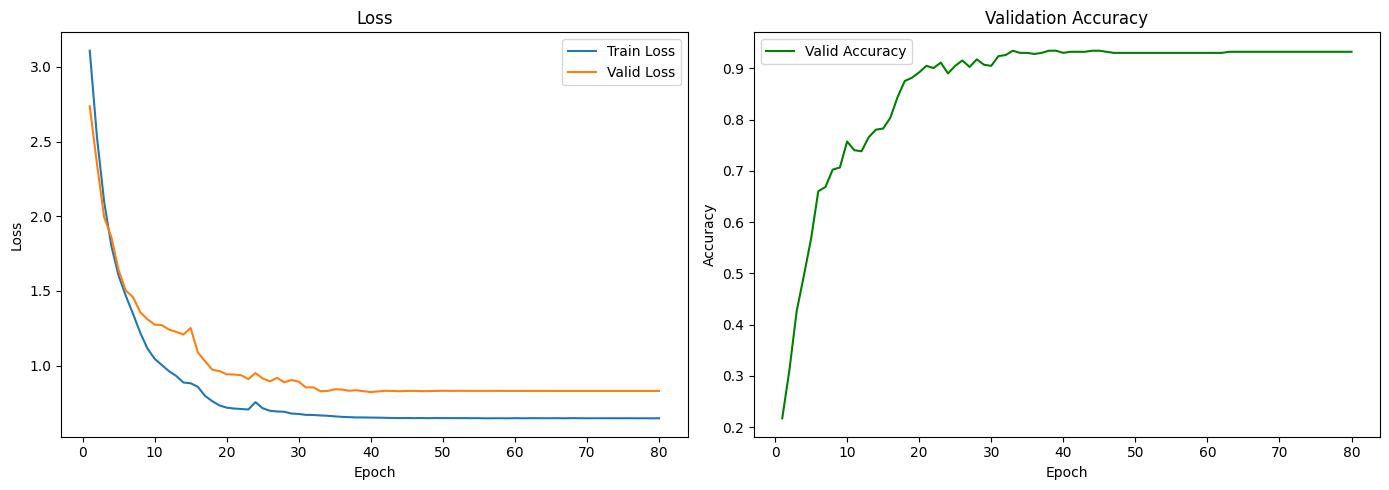

In [ ]:
def evaluate_model(model, X_test, y_test, label_encoder):
    y_pred = model.predict(X_test.astype(np.float32))

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro')
    rec = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}\n")

    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()


def plot_training_history(model):
    history = model.history
    epochs = len(history)

    train_loss = history[:, 'train_loss']
    val_loss = history[:, 'valid_loss']
    val_acc = history[:, 'valid_acc']

    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    ax[0].plot(range(1, epochs + 1), train_loss, label='Train Loss')
    ax[0].plot(range(1, epochs + 1), val_loss, label='Valid Loss')
    ax[0].set_title('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    ax[1].plot(range(1, epochs + 1), val_acc, label='Valid Accuracy', color='green')
    ax[1].set_title('Validation Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

    plt.tight_layout()
    plt.show()


evaluate_model(best_gru_model, X_test_rnn, y_test_rnn, label_encoder)
plot_training_history(best_gru_model)

# Transformer

### Optuna (0,897)

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import optuna
import math
import os
import contextlib

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import TensorDataset
from skorch import NeuralNetClassifier
from skorch.callbacks import Callback, LRScheduler, EpochScoring
from skorch.helper import predefined_split

class AdaptiveEarlyStopping(Callback):
    def __init__(self, patience=5, threshold=0.001):
        self.patience = patience
        self.threshold = threshold
        self.best_score = -np.inf
        self.wait = 0

    def on_epoch_end(self, net, **kwargs):
        current_score = net.history[-1]['valid_acc']
        if current_score - self.best_score > self.threshold:
            self.best_score = current_score
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                old_lr = net.optimizer_.param_groups[0]['lr']
                new_lr = old_lr * 0.5
                print(f"\n[LR Reduction] Reducing LR from {old_lr:.2e} to {new_lr:.2e}")
                for param_group in net.optimizer_.param_groups:
                    param_group['lr'] = new_lr
                self.wait = 0

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len):
        super().__init__()
        self.max_len = max_len
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        seq_len = x.size(1)
        if seq_len > self.max_len:
            raise ValueError(f"Input sequence length {seq_len} exceeds maximum {self.max_len}")
        return x + self.pe[:seq_len, :]

class TransformerClassifier(nn.Module):
    def __init__(self, input_dim, num_classes, num_layers, nhead, d_model, dim_feedforward, dropout, dense, activation, max_len):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len=max_len)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            activation=activation,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Sequential(
            nn.Linear(d_model, dense),
            nn.ReLU(),
            nn.LayerNorm(dense),
            nn.Dropout(dropout),
            nn.Linear(dense, num_classes)
        )

    def forward(self, x):
        x = self.input_proj(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        return self.classifier(x)

def train_transformer(X_train, y_train, X_test, y_test, label_encoder):
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)
    max_seq_len = X_train.shape[1]

    def objective(trial):
        d_model = trial.suggest_categorical('d_model', [64, 128, 256])
        valid_heads = [h for h in [2, 4, 8] if d_model % h == 0]
        if not valid_heads:
            raise optuna.exceptions.TrialPruned()

        model = TransformerClassifier(
            input_dim=X_train.shape[-1],
            num_classes=len(label_encoder.classes_),
            num_layers=trial.suggest_int('num_layers', 2, 4),
            nhead=trial.suggest_categorical('nhead', valid_heads),
            d_model=d_model,
            dim_feedforward=trial.suggest_categorical('dim_feedforward', [256, 512, 1024]),
            dropout=trial.suggest_float('dropout', 0.2, 0.4, step=0.05),
            dense=trial.suggest_categorical('dense', [128, 256, 512]),
            activation=trial.suggest_categorical('activation', ['relu', 'gelu']),
            max_len=max_seq_len
        )

        net = NeuralNetClassifier(
            module=model,
            max_epochs=60,
            batch_size=32,
            optimizer=torch.optim.AdamW,
            optimizer__lr=0.001,
            criterion=nn.CrossEntropyLoss(),
            device='cuda' if torch.cuda.is_available() else 'cpu',
            train_split=predefined_split(TensorDataset(torch.FloatTensor(X_val), torch.LongTensor(y_val))),
            callbacks=[
                ('adapt', AdaptiveEarlyStopping(patience=5)),
                ('sched', LRScheduler(CosineAnnealingLR, T_max=60)),
                ('score', EpochScoring('accuracy', name='valid_acc'))
            ],
            verbose=0
        )

        with open(os.devnull, 'w') as devnull:
            with contextlib.redirect_stdout(devnull):
                net.fit(X_train.astype(np.float32), y_train.astype(np.longlong))

        for epoch, acc in enumerate(net.history[:, 'valid_acc']):
            trial.report(acc, step=epoch)
            if trial.should_prune():
                raise optuna.TrialPruned()

        return max(net.history[:, 'valid_acc'])

    study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
    study.optimize(objective, n_trials=50, show_progress_bar=True)

    print("\nBest hyperparameters:")
    print(study.best_trial.params)

    best_params = study.best_trial.params
    model = TransformerClassifier(
        input_dim=X_train.shape[-1],
        num_classes=len(label_encoder.classes_),
        **best_params,
        max_len=max_seq_len
    )

    final_net = NeuralNetClassifier(
        model,
        max_epochs=60,
        batch_size=32,
        optimizer=torch.optim.AdamW,
        optimizer__lr=0.001,
        criterion=nn.CrossEntropyLoss(),
        device='cuda' if torch.cuda.is_available() else 'cpu',
        train_split=predefined_split(TensorDataset(torch.FloatTensor(X_val), torch.LongTensor(y_val))),
        callbacks=[
            ('adapt', AdaptiveEarlyStopping(patience=5)),
            ('sched', LRScheduler(CosineAnnealingLR, T_max=80)),
            ('score', EpochScoring('accuracy', name='valid_acc'))
        ],
        verbose=1
    )

    final_net.fit(X_train.astype(np.float32), y_train.astype(np.longlong))
    y_pred = final_net.predict(X_test.astype(np.float32))
    print("\nFinal Classification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    return final_net, X_test, y_test, label_encoder

# Usage
X_train_t, X_test_t, y_train_t, y_test_t = features['transformer']
label_encoder = features['label_encoder']

best_transformer = train_transformer(X_train_t, y_train_t, X_test_t, y_test_t, label_encoder)

[I 2025-06-02 06:41:00,024] A new study created in memory with name: no-name-c2d44ad3-239b-4863-88d2-76a479b2f0ab


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-06-02 06:43:32,535] Trial 0 finished with value: 0.8945147679324894 and parameters: {'d_model': 128, 'num_layers': 2, 'nhead': 4, 'dim_feedforward': 1024, 'dropout': 0.25, 'dense': 256, 'activation': 'gelu'}. Best is trial 0 with value: 0.8945147679324894.
[I 2025-06-02 06:47:00,307] Trial 1 finished with value: 0.8839662447257384 and parameters: {'d_model': 128, 'num_layers': 2, 'nhead': 8, 'dim_feedforward': 1024, 'dropout': 0.2, 'dense': 512, 'activation': 'gelu'}. Best is trial 0 with value: 0.8945147679324894.
[I 2025-06-02 06:51:32,320] Trial 2 finished with value: 0.7974683544303798 and parameters: {'d_model': 256, 'num_layers': 2, 'nhead': 8, 'dim_feedforward': 1024, 'dropout': 0.4, 'dense': 256, 'activation': 'gelu'}. Best is trial 0 with value: 0.8945147679324894.
[I 2025-06-02 06:54:43,510] Trial 3 finished with value: 0.8881856540084389 and parameters: {'d_model': 256, 'num_layers': 2, 'nhead': 4, 'dim_feedforward': 512, 'dropout': 0.35000000000000003, 'dense': 256,


Accuracy : 0.8970
Precision: 0.9014
Recall   : 0.8971
F1 Score : 0.8966

Classification Report:
              precision    recall  f1-score   support

           a       0.95      0.82      0.88        22
           b       0.95      0.87      0.91        23
           c       0.89      0.70      0.78        23
           d       0.78      0.91      0.84        23
           e       0.87      0.87      0.87        23
           f       1.00      1.00      1.00        23
           g       0.81      0.74      0.77        23
           h       0.91      0.91      0.91        23
           i       0.79      0.86      0.83        22
           j       0.94      0.74      0.83        23
           k       0.79      0.96      0.86        23
           l       0.85      0.74      0.79        23
           m       0.81      0.96      0.88        23
           n       0.91      0.87      0.89        23
           o       0.85      0.96      0.90        23
           p       0.84      0.91     

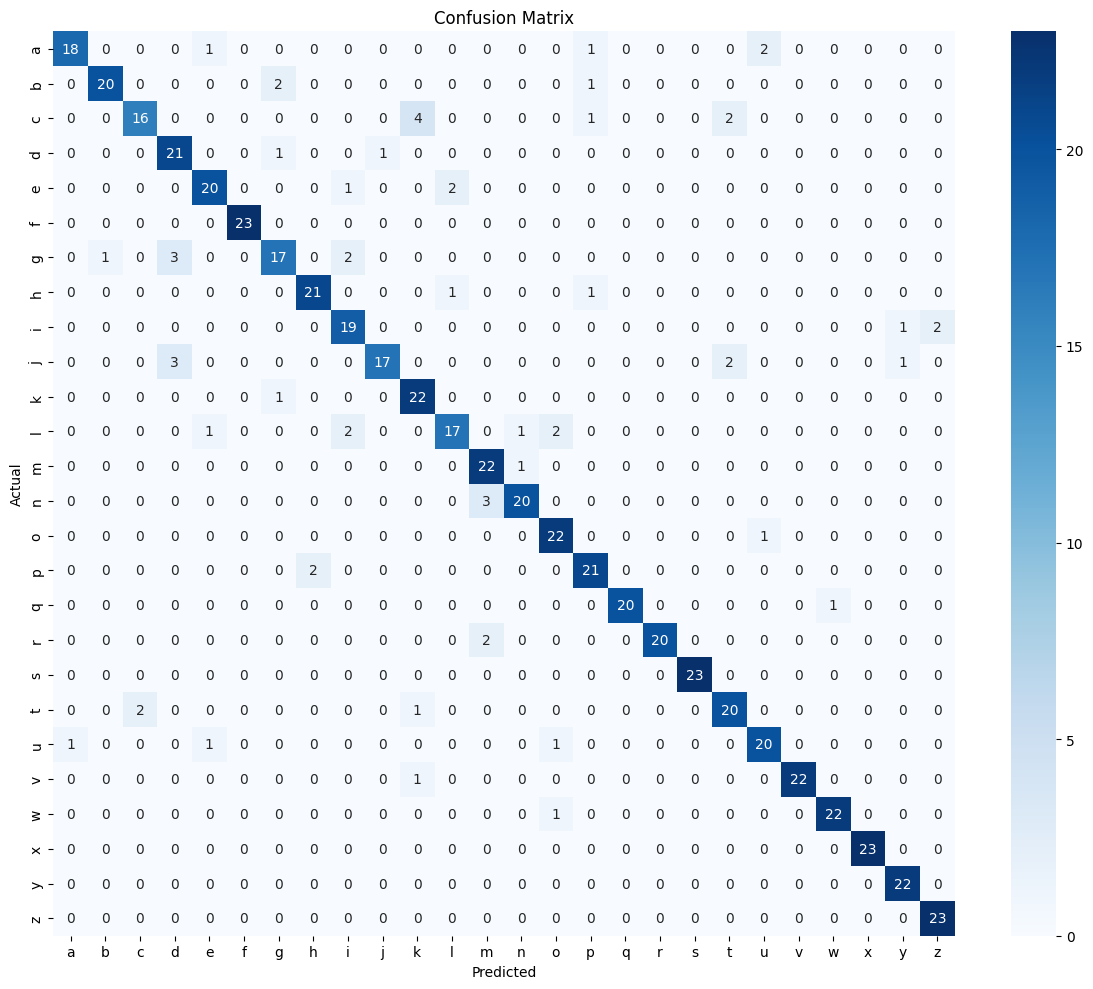

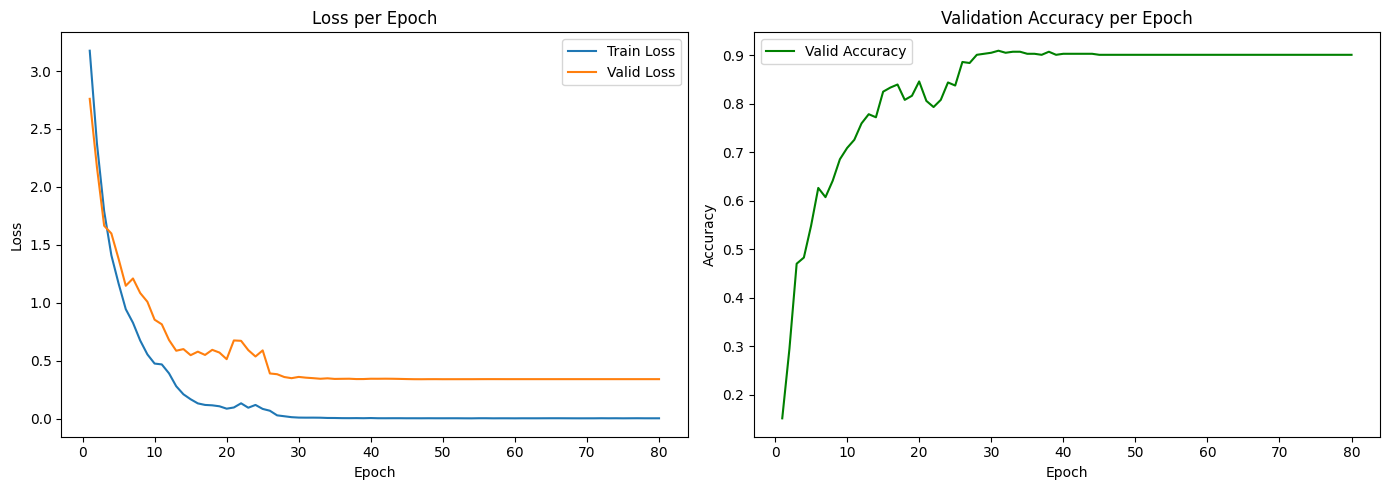

In [ ]:
def evaluate_model(model_tuple):
    model, X_test, y_test, label_encoder = model_tuple
    y_pred = model.predict(X_test.astype(np.float32))

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro')
    rec = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    print(f"\nAccuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}\n")

    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

def plot_training_history(model):
    history = model.history
    epochs = len(history)

    train_loss = history[:, 'train_loss']
    valid_loss = history[:, 'valid_loss']
    valid_acc = history[:, 'valid_acc']

    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    ax[0].plot(range(1, epochs + 1), train_loss, label='Train Loss')
    ax[0].plot(range(1, epochs + 1), valid_loss, label='Valid Loss')
    ax[0].set_title('Loss per Epoch')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    ax[1].plot(range(1, epochs + 1), valid_acc, label='Valid Accuracy', color='green')
    ax[1].set_title('Validation Accuracy per Epoch')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

evaluate_model(best_transformer)
plot_training_history(best_transformer[0])